Author: Jagannath

Date: 25th Sept 2015

Last modified : 25th Sept 2015

The file parses the .ptt file to extract information about the CDS (protein coding genes). <br />
Total number of species analyzed : 2,774 <br />
Total number of genomes (including plasmids) : 5,220 <br />

Example of the format (tab delimited)- 
    Acaryochloris marina MBIC11017 chromosome, complete genome - 1..6503724
	6254 proteins <br />
	Location	Strand	Length	PID	Gene	Synonym	Code	COG	Product
	1627..2319	-	230	158333234	-	AM1_0003	-	COG1051F	NUDIX hydrolase
<br />
Locus_tag is used as the identifier although PID (protein ID) is also provided. The dictionaries created are - 
<ol>
<li>{ locus_tag : [accNbr, rank, geneName, PID (protein ID), (startPos,endPos), COG (COG number with Code)] }</li>
<li>{ COG (w/ code) : ( [locus_tag1, locus_tag2, ...],Count of locus_tags ) }</li>
<li>{ COG(A)-COG(B) : count } # Count of number of times when COG(A) before COG(B); A --> B on the same strand</li>
<li>{ (orgName,accNbr):( (COG(A),COG(B)),....) )
<li>{ COG(A)-COG(B) : set([(orgName,accNbr),...])}
</ol>
[! In future, maybe can think of A --> B (but A and B are on different strands); 
Also this NCBI link has details about its precomputed clusters [link]( ftp://ftp.ncbi.nlm.nih.gov/genomes/Bacteria/CLUSTERS)



In [90]:
from __future__ import division
import os
from collections import defaultdict
import fnmatch
import pickle
import re
import time
import sys

class PTTfile:

    def __init__(self,pttFile):
        self.pttFile = pttFile
        self.accNbr = os.path.split(pttFile)[-1].split('.')[0]
        self.orgName = os.path.split(os.path.split(pttFile)[0])[1]
        self.fnaFile = self.getFnaFile(pttFile) 
        #This is the fasta file of the entire sequence; Note there is substitution of directory
    
    def getFnaFile(self,pttFile):
        s = pttFile
        p = re.compile('allGenomePttFiles')
        fnaFile = p.sub('allGenomeFnaFiles',s)
        fnaFile = fnaFile[:-4]+'.fna'
        return fnaFile
    
    def openPttFile(self):
        f = self.pttFile
        ifile = open(f,'r')
        allLines = ifile.readlines()
        orgInfo = allLines[0]
        self.genome_size = int(orgInfo.strip().split('..')[-1])
        lines = allLines[3:] #Skipping the header
        ifile.close()
        return lines
        
    def getPos(self,loc,strand):
        if strand is '+':
            startPos, endPos = map(int,loc.split('..'))
        else:
            endPos, startPos = map(int,loc.split('..'))
        return (startPos,endPos)

    def makeLinePairs(self,lines):
        # Makes pairs of adjacent genes; By default all genomes are considered circular. So the last pair in the lines 
        # is the last gene --> first gene
        # Returns list of [(line0,line1,rank0),(line1,line2,rank1),...(line4175,line0,rank4175)]
        nbrGenes = len(lines)
        line_first = lines[0]
        line_last = lines[-1]
        lines_shift = lines[1:]
        lines_shift.append(line_first)
        linePairs = zip(lines,lines_shift,range(nbrGenes))
        return linePairs

    def getCDSinfo(self,line,rank):
        # Column information
        # [0]Location	[1]Strand	[2]Length	[3]PID	[4]Gene	[5]Synonym	[6]Code	[7]COG	[8]Product
        (loc, strand, pid, gene, locus_tag, COG) = (line.split('\t')[i] for i in [0,1,3,4,5,7])
        if ',' in COG: # There are some wierd .ptt files wherein the COG is written as COG1,COG1
            COG = COG.split(',')[0]
        if not COG.startswith('-'):
            [COG] = re.findall("COG\d+",COG)
        #pos = getPos(loc,strand)
        pos = map(int,loc.split('..'))
        cds_info = [self.accNbr, rank, locus_tag, gene, pid, pos, strand, COG]
        return cds_info

    def getCOGpair(self,geneA,geneB):
        # Returns a tuple of COGpairs; If orientation is '-' and '-', then the cogpairs are reversed accordingly
        cogPair = ('-','-')
        strA = geneA[-2]
        strB = geneB[-2]
        if strA == strB == '+':
            cogPair = (geneA[-1],geneB[-1])
        elif strA == strB == '-':
            cogPair = (geneB[-1],geneA[-1])
        else:
            cogPair = ('-','-')
        return cogPair
    
    def get_DNAsequence(self):
        ifile = open(self.fnaFile,'r')
        lines = ifile.readlines()
        ifile.close()
        allDNA = ''
        for l in lines[1:]:
            allDNA+=l.strip()
        return allDNA
    
    def getSeq(self,start,end):
        return self.allDNA[start:end]

    def getGC(self,seq):
        try:
            gc = (seq.count('G')+seq.count('C'))/len(seq)
        except ZeroDivisionError:
            gc = 0
        return gc
    
    def getStartEnd(self,lposB,rposA):
        dist = lposB - rposA
        if dist >= 0:
            start = rposA
            end = lposB
        else:
            if abs(dist) > self.genome_size/100: # Some large number; This is for gene pairs (first and last gene)
                startA = rposA
                endA = self.genome_size
                startB = 0
                endB = lposB
                return ((startA,endA),(startB,endB))
            else:
                start = lposB
                end = rposA
        return ((start,end),True)

    def calculate_intergenicDistance(self,lposB,rposA):
        dist = lposB - rposA
        if abs(dist) > self.genome_size/100: # Some large number; This is for gene pairs (first and last gene)
            dist = (self.genome_size - rposA) + lposB
        return dist
    
    def getGCcontent(self,(lposA,rposA),(lposB,rposB)):
        seqA = self.getSeq(lposA,rposA)
        seqB = self.getSeq(lposB,rposB)
        geneA_GC = self.getGC(seqA)
        geneB_GC = self.getGC(seqB)
        
        # Intergenic
        between1,between2 = self.getStartEnd(lposB,rposA)
        if between2 is True:
            start, end = between1
            seq = self.getSeq(start,end)
        else:
            startA,endA = between1
            seq1 = self.getSeq(startA,endA)
            startB,endB = between2
            seq2 = self.getSeq(startB,endB)
            seq = seq1 + seq2

        intergenic_GC = self.getGC(seq)
        return geneA_GC,geneB_GC,intergenic_GC
    
    def populateDict(self):
        self.allDNA = self.get_DNAsequence()
        lines = self.openPttFile()
        linePairs = self.makeLinePairs(lines)
        for pair in linePairs:
            cogPair = ('-','-')
            lineA,lineB,rankA = pair
            geneA = self.getCDSinfo(lineA,rankA)
            geneB = self.getCDSinfo(lineB,rankA+1)
            cogPair = self.getCOGpair(geneA,geneB)
            cogPair_count_dict[cogPair]+=1
            cog_locusTagList_dict[geneA[-1]].append(geneA[2])
            locus_cog_dict[geneA[2]] = geneA[7]
            lposA,rposA = geneA[5]
            lposB,rposB = geneB[5]
            geneA_GC,geneB_GC, intergenic_GC = self.getGCcontent((lposA,rposA),(lposB,rposB))
            bp_dist = self.calculate_intergenicDistance(lposB,rposA)
            if not cogPair == ('-','-'):
                org_cogPair_dict[(self.orgName,self.accNbr)].append(cogPair)
                org_cog_dict[(self.orgName,self.accNbr)].append(cogPair[0])
                cogPair_org_dict[cogPair].append((self.orgName,self.accNbr))
                cogPair_bpdist_dict[cogPair].append(bp_dist)
                cogPair_GCcontent_dict[cogPair].append((geneA_GC,geneB_GC,intergenic_GC))
                
# Defining dictionary
cogPair_count_dict = defaultdict(int)
cog_locusTagList_dict = defaultdict(list)
locus_cog_dict = dict()
org_cogPair_dict = defaultdict(list) 
org_cog_dict = defaultdict(list)
cogPair_org_dict = defaultdict(list)
cogPair_bpdist_dict = defaultdict(list)
cogPair_GCcontent_dict = defaultdict(list)

sourceDir = '/home/jaggu/research/allGenomePttFiles'
pklPath = '/home/jaggu/research/projectFiles/operons/pklFiles'

def locate(pattern, root=os.curdir):
    '''Locate all files matching supplied filename pattern in and
    below supplied root directory.'''
    allFiles = []
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            allFiles.append(os.path.join(path,filename))
    return allFiles

def savePkl(db,pklFname):
    f = os.path.join(pklPath,pklFname)
    pickle.dump(db,open(f,'w'))
    return 

def main(sourceDir):
    allPttFiles = locate('*.ptt',sourceDir)
    for pttFile in allPttFiles:
        #print "Parsing %s ...."%(pttFile)
        genome = PTTfile(pttFile)
        genome.populateDict()
    savePkl(cogPair_count_dict,'cogPair_count.dict.pkl')
    savePkl(cog_locusTagList_dict,'cog_locusTag.dict.pkl')
    savePkl(locus_cog_dict,'locus_cog.dict.pkl')
    savePkl(org_cogPair_dict,'org_cogPair.dict.pkl')
    savePkl(org_cog_dict,'org_cogList.dict.pkl')
    savePkl(cogPair_org_dict,'cogPair_org.dict.pkl')
    savePkl(cogPair_bpdist_dict,'cogPair_bpdist.dict.pkl')
    savePkl(cogPair_GCcontent_dict,'cogPair_GCcontent.dict.pkl')
    print "Parsed all files at",time.ctime()
        
def test_case():
    orgName = 'Bacillus_subtilis_168_uid57675'
    pttFile = 'NC_000964.ptt'
    test = PTTfile(os.path.join(sourceDir,orgName,pttFile))
    test.get_DNAsequence()
    test.populateDict()
    
    #print org_cogPair_dict.items()[0]
    #print len(set(org_cog_dict.values()[0]))
    #print len(org_cog_dict.values()[0])
    #print cogPair_count_dict
    #print cogPair_bpdist_dict
    #print cogPair_GCcontent_dict.items()[10]

main(sourceDir)
#test_case()

Parsing /home/jaggu/research/allGenomePttFiles/Nostoc_PCC_7120_uid57803/NC_003272.ptt ....
Parsing /home/jaggu/research/allGenomePttFiles/Nostoc_PCC_7120_uid57803/NC_003276.ptt ....
Parsing /home/jaggu/research/allGenomePttFiles/Nostoc_PCC_7120_uid57803/NC_003241.ptt ....
Parsing /home/jaggu/research/allGenomePttFiles/Nostoc_PCC_7120_uid57803/NC_003240.ptt ....
Parsing /home/jaggu/research/allGenomePttFiles/Nostoc_PCC_7120_uid57803/NC_003273.ptt ....
Parsing /home/jaggu/research/allGenomePttFiles/Nostoc_PCC_7120_uid57803/NC_003270.ptt ....
Parsing /home/jaggu/research/allGenomePttFiles/Nostoc_PCC_7120_uid57803/NC_003267.ptt ....
Parsing /home/jaggu/research/allGenomePttFiles/Acetobacter_pasteurianus_IFO_3283_01_uid59279/NC_013210.ptt ....
Parsing /home/jaggu/research/allGenomePttFiles/Acetobacter_pasteurianus_IFO_3283_01_uid59279/NC_013215.ptt ....
Parsing /home/jaggu/research/allGenomePttFiles/Acetobacter_pasteurianus_IFO_3283_01_uid59279/NC_013209.ptt ....
Parsing /home/jaggu/researc

In [26]:
# Mapping KEGG orthogroup (kog) to COG orthogroup or a list of COG (cog)
# This is a many to many set mapping; The file was downloaded from KEGG database.
import os
import re
from collections import defaultdict
import cPickle as pickle

sourceDir = '/home/jaggu/research/downloads/cogDB'
fname = 'kog2cog.txt'
ifile = open(os.path.join(sourceDir,fname),'r')
lines = ifile.readlines()
ifile.close()

def savePkl(db,pklFname):
    pklPath = '/home/jaggu/research/projectFiles/operons/pklFiles'
    f = os.path.join(pklPath,pklFname)
    pickle.dump(db,open(f,'w'))
    return 

# Dictionary 
kog_cogList_dict = dict()
cog_kogList_dict = defaultdict(list)

for line in lines[1:]:
    kog,cogStr = line.split('\t')
    cogList = re.findall("COG\d+",cogStr)
    kog_cogList_dict[kog]=cogList
    for cog in cogList:
        cog_kogList_dict[cog].append(kog) 

savePkl(kog_cogList_dict,'kog_cogList.dict.pkl')
savePkl(cog_kogList_dict,'cog_kogList.dict.pkl')

print "Dictionaries pickled"


Dictionaries pickled


In [56]:
from __future__ import division

genome_size = len(allDNA)
def getSeq(start,end):
    seq = allDNA[start:end]
    return seq

def getGC(seq):
    gc = (seq.count('G')+seq.count('C'))/len(seq)
    return gc
    
def getStartEnd(lposB,rposA):
    dist = lposB - rposA
    if dist >= 0:
        start = rposA
        end = lposB
    else:
        if abs(dist) > genome_size/100: # Some large number; This is for gene pairs (first and last gene)
            startA = rposA
            endA = genome_size
            startB = 0
            endB = lposB
            return ((startA,endA),(startB,endB))
        else:
            start = lposB
            end = rposA
    return ((start,end),True)

geneA = ['NC_000964', 0, 'BSU00010', 'dnaA', '16077069', [410, 1750], '+', 'COG0593'] 
geneB = ['NC_000964', 1, 'BSU00020', 'dnaN', '16077070', [1939, 3075], '+', 'COG0592']
lposA,rposA = geneA[5]
lposB,rposB = geneB[5]

between1,between2 = getStartEnd(lposB,rposA)
if between2 is True:
    start, end = between1
    seq = getSeq(start,end)
else:
    startA,endA = between1
    seq1 = getSeq(startA,endA)
    startB,endB = between2
    seq2 = getSeq(startB,endB)
    seq = seq1 + seq2
gc = getGC(seq)
print gc

seqA = getSeq(lposA,rposA)
seqB = getSeq(lposB,rposB)
print getGC(seqA), getGC(seqB)


0.37037037037
0.401492537313 0.399647887324


In [5]:
import time
import os
import pickle

def loadPkl(fname):
    pklDir = '/home/jaggu/research/projectFiles/operons/pklFiles'
    f = os.path.join(pklDir,fname)
    db = pickle.load(open(f))
    return db

def savePkl(db,pklFname):
    pklDir = '/home/jaggu/research/projectFiles/operons/pklFiles'    
    f = os.path.join(pklDir,pklFname)
    pickle.dump(db,open(f,'w'))
    return 

cogPair_fgocInfo_dict = loadPkl('cogPair_fgocInfo.dict.pkl')
cog_func_dict = loadPkl('cogFunc.dict.pkl')
cog_locusTag_dict = loadPkl('cog_locusTag.dict.pkl')
print "Dictionaries loaded",time.ctime()

Dictionaries loaded Sat Nov 21 19:37:50 2015


4766
Total number of genes mapped :  4046852
/home/jaggu/research/projectFiles/operons/figures/COG_function_composition.totalLtag.bar.svg


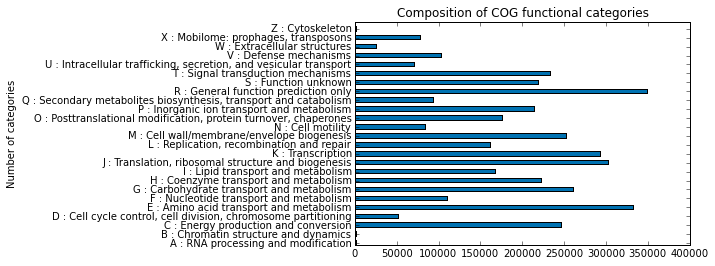

In [33]:
# Statistics of the COG functions
import os
import pickle
import collections

imgDir = '/home/jaggu/research/projectFiles/operons/figures'

% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

code_fname = os.path.join('/home/jaggu/research/downloads/cogDB','fun2003-2014.tab')
ifile = open(code_fname)
lines = ifile.readlines()
ifile.close()

print len(cog_locusTag_dict)

code_category_dict = dict()
for line in lines[1:]:
    code, name = line.strip().split('\t')
    code_category_dict[code]=name

category_counts_dict = collections.defaultdict(int)

for cog, ltag in cog_locusTag_dict.items():
    codeNames, func = cog_func_dict.get(cog,(None,None))

    if func:
        if len(codeNames)>1:
            catSplit = list(codeNames)
            for code in catSplit: 
                category_counts_dict[code]+=len(ltag)
        else:
            category_counts_dict[codeNames]+=len(ltag)

            
xNames = list()
xList = list()
yList = list()

for code, nbr in sorted(category_counts_dict.items()):
    wname = code + ' : ' + code_category_dict[code]
    xNames.append(wname)
    yList.append(nbr)

print "Total number of genes mapped : ",sum(yList)
width = 0.5
xList = np.arange(len(xNames))
rects = plt.barh(xList, yList, width, color='#0072B2')
plt.yticks(xList+0.2,xNames,rotation='horizontal')
plt.ylabel('Number of categories')
plt.title('Composition of COG functional categories ')
plt.xlim([0,400000])
# Saving figure
fname = 'COG_function_composition.totalLtag.bar.svg'
f = os.path.join(imgDir,fname)
print f
plt.savefig(f,dpi=300)
plt.show()
